Ver: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### Se debe tener las últimas versiones de Keras y TensorFlow!

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
shuffle_data = True
top_24 = True
dog_breed_train_path = 'Dog Breed/train/'
dog_breed_val_path = 'Dog Breed/val/'
dog_breed_labels_path = 'Dog Breed/labels.csv'
if top_24:
    dog_breed_train_path = 'Dog Breed/train_top_24/'
    dog_breed_val_path = 'Dog Breed/val_top_24/'

# read addresses and labels
labels = pd.read_csv(dog_breed_labels_path)

# to shuffle data
if shuffle_data:
    labels = labels.sample(frac=1)

### Ojo: el siguiente bloque de código sólo se ejecuta una vez; sirve para mover los archivos de imágenes de cada clase a sus respectivas carpetas

In [3]:
# load dataset and labels into variables

# use 20% of the train set to create a validation set and another 20% for a test set
train_labels = labels.iloc[:int(0.8*len(labels))]
val_labels = labels.iloc[int(0.8*len(labels)):]

# a numpy array to save the mean of the images

# loop over train addresses
for i, (index, img_id, label) in enumerate(train_labels.itertuples()):
    # print how many images are saved every 1000 images
    if (i+1) % 1000 == 0 or i+1 == len(train_labels):
        print ('Train data: {0}/{1}'.format(i+1, len(train_labels)))
        print('Processing: original_index={0}, id={1}, label={2}'.format(index, img_id, label))

    # move the image to a subdirectory named after its label
    if not os.path.isdir(os.path.join(dog_breed_train_path, label)):
        os.mkdir(os.path.join(dog_breed_train_path, label))
    os.rename(dog_breed_train_path+img_id+'.jpg', dog_breed_train_path+label+'/'+img_id+'.jpg')

for i, (index, img_id, label) in enumerate(val_labels.itertuples()):
    # print how many images are saved every 1000 images
    if (i+1) % 1000 == 0 or i+1 == len(val_labels):
        print ('Validation data: {0}/{1}'.format(i+1, len(val_labels)))
        print('Processing: original_index={0}, id={1}, label={2}'.format(index, img_id, label))

    # move the image to a subdirectory named after its label
    if not os.path.isdir(os.path.join(dog_breed_val_path, label)):
        os.mkdir(os.path.join(dog_breed_val_path, label))
    os.rename(dog_breed_train_path+img_id+'.jpg', dog_breed_val_path+label+'/'+img_id+'.jpg')

# aqui va el centrado de datos

Train data: 1000/8177
Processing: original_index=5918, id=955fdc8f29b6b78c8888d0dfdd1c6a8d, label=mexican_hairless
Train data: 2000/8177
Processing: original_index=6993, id=af465eb9b2371bb3639518f0daa8529e, label=border_terrier
Train data: 3000/8177
Processing: original_index=6007, id=978a9eee19b794afb59da56af20e8714, label=blenheim_spaniel
Train data: 4000/8177
Processing: original_index=8480, id=d4dbe4468560bb227aac6627237ab9ec, label=bedlington_terrier
Train data: 5000/8177
Processing: original_index=8665, id=d96c7a1efc7455d533bb2beb4da27896, label=tibetan_mastiff
Train data: 6000/8177
Processing: original_index=5755, id=916acab38c9b1ef122851c0815c6826a, label=tibetan_mastiff
Train data: 7000/8177
Processing: original_index=2440, id=3cc8881795884439670f3b6722ad1482, label=african_hunting_dog
Train data: 8000/8177
Processing: original_index=2808, id=450652d3c78bcead07a39fd386dca46f, label=boxer
Train data: 8177/8177
Processing: original_index=9054, id=e381b4aaa19c31ef6765ab0d0af205c9

In [7]:
import scipy.stats as sts

freqs = sts.itemfreq(labels['breed'])

freqs = sorted(freqs, key=lambda x: -x[1])

(freqs[:24])

[array(['scottish_deerhound', 126], dtype=object),
 array(['maltese_dog', 117], dtype=object),
 array(['afghan_hound', 116], dtype=object),
 array(['entlebucher', 115], dtype=object),
 array(['bernese_mountain_dog', 114], dtype=object),
 array(['shih-tzu', 112], dtype=object),
 array(['great_pyrenees', 111], dtype=object),
 array(['pomeranian', 111], dtype=object),
 array(['basenji', 110], dtype=object),
 array(['samoyed', 109], dtype=object),
 array(['airedale', 107], dtype=object),
 array(['tibetan_terrier', 107], dtype=object),
 array(['cairn', 106], dtype=object),
 array(['leonberg', 106], dtype=object),
 array(['beagle', 105], dtype=object),
 array(['japanese_spaniel', 105], dtype=object),
 array(['australian_terrier', 102], dtype=object),
 array(['blenheim_spaniel', 102], dtype=object),
 array(['miniature_pinscher', 102], dtype=object),
 array(['irish_wolfhound', 101], dtype=object),
 array(['lakeland_terrier', 99], dtype=object),
 array(['saluki', 99], dtype=object),
 array(['pa

In [9]:
s = 0
for d,f in freqs[:24]:
    s += f
s

2573

### Hay que jugar un poco con la arquitectura de la CNN. Mi PC no aguanta un modelo que tenga más de ~12 millones de parámetros, así que las opciones son achicar las imágenes de entrada (pic_dimension) y/o disminuir la cantidad de neuronas del modelo:

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

n_classes = 24

c:\program files\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
pic_dimension = 112

modelo_1 = Sequential()
modelo_1.add(Conv2D(64, (3, 3), padding='same', input_shape=(pic_dimension, pic_dimension, 3)))
modelo_1.add(Activation('relu'))
modelo_1.add(MaxPooling2D(pool_size=(2, 2)))
#modelo_1.add(Dropout(0.3))
modelo_1.add(Conv2D(64, (3, 3), padding='same'))
modelo_1.add(Activation('relu'))
modelo_1.add(MaxPooling2D(pool_size=(2, 2)))
#modelo_1.add(Dropout(0.3))
modelo_1.add(Conv2D(128, (3, 3), padding='same'))
modelo_1.add(Activation('relu'))
modelo_1.add(MaxPooling2D(pool_size=(2, 2)))
#modelo_1.add(Dropout(0.3))
modelo_1.add(Conv2D(128, (3, 3), padding='same'))
modelo_1.add(Activation('relu'))
modelo_1.add(MaxPooling2D(pool_size=(2, 2)))
#modelo_1.add(Dropout(0.3))
modelo_1.add(Flatten())
modelo_1.add(Dense(1024))
modelo_1.add(Activation('relu'))
modelo_1.add(Dropout(0.3))
modelo_1.add(Dense(n_classes))
modelo_1.add(Activation('softmax'))
modelo_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 112, 112, 64)      1792      
_________________________________________________________________
activation_7 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
activation_8 (Activation)    (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
__________

In [8]:
# compilación del modelo
from keras.callbacks import Callback
from keras.optimizers import SGD, RMSprop

modelo_1.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

La cantidad de datos del dataset es muy poco (10222 imagenes) respecto a la dimensionalidad del mismo. Por lo tanto, es útil aumentar artificialmente el dataset aplicando distorsiones aleatorias a cada imagen, de manera que el modelo en entrenamiento nunca vea la misma imagen más de una vez.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

Found 2089 images belonging to 24 classes.
Found 484 images belonging to 24 classes.


In [10]:
# entrenamiento de la CNN.
import tensorflow as tf

conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_test = {'test_loss': [], 'test_acc': []}

results = modelo_1.fit_generator(
        train_generator, 
        steps_per_epoch=2573//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=50,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_1.save_weights('modelo_top_24.h5')

Epoch 1/50
80/80 [==============================] - 30s 370ms/step - loss: 3.2978 - acc: 0.0441 - val_loss: 3.1767 - val_acc: 0.0354
Epoch 2/50
80/80 [==============================] - 13s 166ms/step - loss: 3.1755 - acc: 0.0594 - val_loss: 3.1225 - val_acc: 0.0979
Epoch 3/50
80/80 [==============================] - 13s 167ms/step - loss: 3.1247 - acc: 0.0758 - val_loss: 3.0695 - val_acc: 0.1000
Epoch 4/50
80/80 [==============================] - 14s 169ms/step - loss: 3.0637 - acc: 0.1026 - val_loss: 2.9336 - val_acc: 0.1771
Epoch 5/50
80/80 [==============================] - 14s 179ms/step - loss: 2.9613 - acc: 0.1141 - val_loss: 2.7965 - val_acc: 0.2021
Epoch 6/50
80/80 [==============================] - 13s 164ms/step - loss: 2.8872 - acc: 0.1409 - val_loss: 2.7888 - val_acc: 0.1625
Epoch 7/50
80/80 [==============================] - 13s 167ms/step - loss: 2.8572 - acc: 0.1524 - val_loss: 2.7159 - val_acc: 0.2042
Epoch 8/50
80/80 [==============================] - 13s 166ms/step - 

In [20]:
pic_dimension = 150

modelo_2 = Sequential()
modelo_2.add(Conv2D(64, (3, 3), padding='same', input_shape=(pic_dimension, pic_dimension, 3)))
modelo_2.add(Activation('relu'))
modelo_2.add(MaxPooling2D(pool_size=(2, 2)))
modelo_2.add(Conv2D(64, (3, 3), padding='same'))
modelo_2.add(Activation('relu'))
modelo_2.add(MaxPooling2D(pool_size=(2, 2)))
modelo_2.add(Conv2D(128, (3, 3), padding='same'))
modelo_2.add(Activation('relu'))
modelo_2.add(MaxPooling2D(pool_size=(2, 2)))
modelo_2.add(Conv2D(128, (3, 3), padding='same'))
modelo_2.add(Activation('relu'))
modelo_2.add(MaxPooling2D(pool_size=(2, 2)))
modelo_2.add(Flatten())
modelo_2.add(Dense(1024))
modelo_2.add(Activation('relu'))
modelo_2.add(Dropout(0.3))
modelo_2.add(Dense(n_classes))
modelo_2.add(Activation('softmax'))
modelo_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 150, 150, 64)      1792      
_________________________________________________________________
activation_25 (Activation)   (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 75, 75, 64)        36928     
_________________________________________________________________
activation_26 (Activation)   (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 37, 37, 128)       73856     
__________

In [21]:
# compilación del modelo
from keras.callbacks import Callback
from keras.optimizers import SGD, RMSprop

modelo_2.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 25

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

Found 2089 images belonging to 24 classes.
Found 484 images belonging to 24 classes.


In [23]:
# entrenamiento de la CNN.
import tensorflow as tf

conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_test = {'test_loss': [], 'test_acc': []}

results = modelo_2.fit_generator(
        train_generator, 
        steps_per_epoch=2573//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=50,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_2.save_weights('modelo_2_top_24.h5')

Epoch 1/50
102/102 [==============================] - 21s 204ms/step - loss: 3.2545 - acc: 0.0435 - val_loss: 3.1568 - val_acc: 0.0821
Epoch 2/50
102/102 [==============================] - 18s 180ms/step - loss: 3.1626 - acc: 0.0623 - val_loss: 3.1284 - val_acc: 0.0779
Epoch 3/50
102/102 [==============================] - 18s 172ms/step - loss: 3.1217 - acc: 0.0729 - val_loss: 3.0325 - val_acc: 0.1284
Epoch 4/50
102/102 [==============================] - 18s 179ms/step - loss: 3.0378 - acc: 0.0917 - val_loss: 2.9179 - val_acc: 0.1242
Epoch 5/50
102/102 [==============================] - 19s 185ms/step - loss: 2.9801 - acc: 0.1198 - val_loss: 2.8504 - val_acc: 0.1663
Epoch 6/50
102/102 [==============================] - 18s 175ms/step - loss: 2.9067 - acc: 0.1354 - val_loss: 2.7751 - val_acc: 0.1832
Epoch 7/50
102/102 [==============================] - 18s 175ms/step - loss: 2.8399 - acc: 0.1532 - val_loss: 2.7013 - val_acc: 0.2168
Epoch 8/50
102/102 [==============================] - 1

ResourceExhaustedError: OOM when allocating tensor with shape[25,64,75,75] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_3/RMSprop/gradients/max_pooling2d_17/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@max_pooling2d_17/MaxPool"], data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_25/Relu, max_pooling2d_17/MaxPool, training_3/RMSprop/gradients/conv2d_18/convolution_grad/Conv2DBackpropInput)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_3/RMSprop/gradients/max_pooling2d_17/MaxPool_grad/MaxPoolGrad', defined at:
  File "c:\program files\python35\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\program files\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\program files\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\program files\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\program files\python35\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\program files\python35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\program files\python35\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\program files\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\program files\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\program files\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\program files\python35\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\program files\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\program files\python35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\program files\python35\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\program files\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\program files\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-6326003604d5>", line 18, in <module>
    validation_steps=484//batch_size,
  File "c:\program files\python35\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\keras\models.py", line 1227, in fit_generator
    initial_epoch=initial_epoch)
  File "c:\program files\python35\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\keras\engine\training.py", line 2016, in fit_generator
    self._make_train_function()
  File "c:\program files\python35\lib\site-packages\keras\engine\training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "c:\program files\python35\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "c:\program files\python35\lib\site-packages\keras\optimizers.py", line 225, in get_updates
    grads = self.get_gradients(loss, params)
  File "c:\program files\python35\lib\site-packages\keras\optimizers.py", line 73, in get_gradients
    grads = K.gradients(loss, params)
  File "c:\program files\python35\lib\site-packages\keras\backend\tensorflow_backend.py", line 2394, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 609, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "c:\program files\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 375, in _MaybeCompile
    return grad_fn()  # Exit early
  File "c:\program files\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 609, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "c:\program files\python35\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 583, in _MaxPoolGrad
    data_format=op.get_attr("data_format"))
  File "c:\program files\python35\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 3755, in _max_pool_grad
    data_format=data_format, name=name)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'max_pooling2d_17/MaxPool', defined at:
  File "c:\program files\python35\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "c:\program files\python35\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-24db1011c97e>", line 6, in <module>
    modelo_2.add(MaxPooling2D(pool_size=(2, 2)))
  File "c:\program files\python35\lib\site-packages\keras\models.py", line 489, in add
    output_tensor = layer(self.outputs[0])
  File "c:\program files\python35\lib\site-packages\keras\engine\topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "c:\program files\python35\lib\site-packages\keras\layers\pooling.py", line 154, in call
    data_format=self.data_format)
  File "c:\program files\python35\lib\site-packages\keras\layers\pooling.py", line 217, in _pooling_function
    pool_mode='max')
  File "c:\program files\python35\lib\site-packages\keras\backend\tensorflow_backend.py", line 3466, in pool2d
    data_format=tf_data_format)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 2043, in max_pool
    name=name)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 3459, in _max_pool
    data_format=data_format, name=name)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "c:\program files\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[25,64,75,75] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_3/RMSprop/gradients/max_pooling2d_17/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@max_pooling2d_17/MaxPool"], data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_25/Relu, max_pooling2d_17/MaxPool, training_3/RMSprop/gradients/conv2d_18/convolution_grad/Conv2DBackpropInput)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [5]:
pic_dimension = 64

modelo_3 = Sequential()
modelo_3.add(Conv2D(64, (3, 3), padding='same', input_shape=(pic_dimension, pic_dimension, 3)))
modelo_3.add(Activation('relu'))
modelo_3.add(MaxPooling2D(pool_size=(2, 2)))
modelo_3.add(Conv2D(64, (3, 3), padding='same'))
modelo_3.add(Activation('relu'))
modelo_3.add(MaxPooling2D(pool_size=(2, 2)))
modelo_3.add(Conv2D(128, (3, 3), padding='same'))
modelo_3.add(Activation('relu'))
modelo_3.add(MaxPooling2D(pool_size=(2, 2)))
modelo_3.add(Conv2D(128, (3, 3), padding='same'))
modelo_3.add(Activation('relu'))
modelo_3.add(MaxPooling2D(pool_size=(2, 2)))
modelo_3.add(Flatten())
modelo_3.add(Dense(1024))
modelo_3.add(Activation('relu'))
modelo_3.add(Dropout(0.3))
modelo_3.add(Dense(n_classes))
modelo_3.add(Activation('softmax'))
modelo_3.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
con

In [6]:
# compilación del modelo
from keras.callbacks import Callback
from keras.optimizers import SGD, RMSprop

modelo_3.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 90

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

Found 2089 images belonging to 24 classes.
Found 484 images belonging to 24 classes.


In [8]:
# entrenamiento de la CNN.
import tensorflow as tf

conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_test = {'test_loss': [], 'test_acc': []}

results = modelo_3.fit_generator(
        train_generator, 
        steps_per_epoch=2573//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=50,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_3.save_weights('modelo_3_top_24.h5')

Epoch 1/50
28/28 [==============================] - 11s 410ms/step - loss: 3.2282 - acc: 0.0425 - val_loss: 3.1751 - val_acc: 0.0533
Epoch 2/50
28/28 [==============================] - 9s 328ms/step - loss: 3.1745 - acc: 0.0553 - val_loss: 3.1719 - val_acc: 0.0667
Epoch 3/50
28/28 [==============================] - 9s 317ms/step - loss: 3.2341 - acc: 0.0509 - val_loss: 3.1676 - val_acc: 0.0533
Epoch 4/50
28/28 [==============================] - 9s 329ms/step - loss: 3.1204 - acc: 0.0734 - val_loss: 3.0915 - val_acc: 0.1133
Epoch 5/50
28/28 [==============================] - 9s 326ms/step - loss: 3.0708 - acc: 0.0936 - val_loss: 3.0214 - val_acc: 0.1156
Epoch 6/50
28/28 [==============================] - 10s 344ms/step - loss: 3.0160 - acc: 0.1128 - val_loss: 2.8536 - val_acc: 0.1667
Epoch 7/50
28/28 [==============================] - 9s 333ms/step - loss: 2.9730 - acc: 0.1251 - val_loss: 2.8590 - val_acc: 0.1644
Epoch 8/50
28/28 [==============================] - 9s 330ms/step - loss: 

In [15]:
pic_dimension = 224

modelo_4 = Sequential()
modelo_4.add(Conv2D(64, (3, 3), padding='same', input_shape=(pic_dimension, pic_dimension, 3)))
modelo_4.add(Activation('relu'))
modelo_4.add(MaxPooling2D(pool_size=(2, 2)))
modelo_4.add(Conv2D(64, (3, 3), padding='same'))
modelo_4.add(Activation('relu'))
modelo_4.add(MaxPooling2D(pool_size=(2, 2)))
modelo_4.add(Conv2D(128, (3, 3), padding='same'))
modelo_4.add(Activation('relu'))
modelo_4.add(MaxPooling2D(pool_size=(2, 2)))
modelo_4.add(Conv2D(128, (3, 3), padding='same'))
modelo_4.add(Activation('relu'))
modelo_4.add(MaxPooling2D(pool_size=(2, 2)))
modelo_4.add(Flatten())
modelo_4.add(Dense(512))
modelo_4.add(Activation('relu'))
modelo_4.add(Dropout(0.3))
modelo_4.add(Dense(256))
modelo_4.add(Activation('relu'))
modelo_4.add(Dropout(0.3))
modelo_4.add(Dense(n_classes))
modelo_4.add(Activation('softmax'))
modelo_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_19 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
activation_20 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 128)       73856     
__________

In [16]:
# compilación del modelo
from keras.callbacks import Callback
from keras.optimizers import SGD, RMSprop

modelo_4.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 10

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

Found 2089 images belonging to 24 classes.
Found 484 images belonging to 24 classes.


In [18]:
# entrenamiento de la CNN.
import tensorflow as tf

conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_test = {'test_loss': [], 'test_acc': []}

results = modelo_4.fit_generator(
        train_generator, 
        steps_per_epoch=2573//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=50,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_4.save_weights('modelo_4_top_24.h5')

Epoch 1/50
257/257 [==============================] - 34s 133ms/step - loss: 3.2327 - acc: 0.0444 - val_loss: 3.1808 - val_acc: 0.0333
Epoch 2/50
257/257 [==============================] - 32s 124ms/step - loss: 3.1831 - acc: 0.0506 - val_loss: 3.1495 - val_acc: 0.0688
Epoch 3/50
257/257 [==============================] - 32s 125ms/step - loss: 3.1485 - acc: 0.0626 - val_loss: 3.0543 - val_acc: 0.0896
Epoch 4/50
257/257 [==============================] - 34s 131ms/step - loss: 3.0666 - acc: 0.0783 - val_loss: 3.0267 - val_acc: 0.0625
Epoch 5/50
257/257 [==============================] - 34s 133ms/step - loss: 3.0291 - acc: 0.0837 - val_loss: 3.0702 - val_acc: 0.0813
Epoch 6/50
257/257 [==============================] - 34s 131ms/step - loss: 2.9942 - acc: 0.0895 - val_loss: 2.8566 - val_acc: 0.1313
Epoch 7/50
257/257 [==============================] - 32s 125ms/step - loss: 2.9355 - acc: 0.1082 - val_loss: 2.7979 - val_acc: 0.1438
Epoch 8/50
257/257 [==============================] - 3

In [80]:
pic_dimension = 150

modelo_5 = Sequential()
modelo_5.add(Conv2D(64, (3, 3), padding='same', input_shape=(pic_dimension, pic_dimension, 3)))
modelo_5.add(Activation('relu'))
modelo_5.add(MaxPooling2D(pool_size=(2, 2)))
modelo_5.add(Conv2D(64, (3, 3), padding='same'))
modelo_5.add(Activation('relu'))
modelo_5.add(MaxPooling2D(pool_size=(2, 2)))
modelo_5.add(Conv2D(128, (3, 3), padding='same'))
modelo_5.add(Activation('relu'))
modelo_5.add(MaxPooling2D(pool_size=(2, 2)))
modelo_5.add(Conv2D(128, (3, 3), padding='same'))
modelo_5.add(Activation('relu'))
modelo_5.add(MaxPooling2D(pool_size=(2, 2)))
modelo_5.add(Flatten())
modelo_5.add(Dense(512))
modelo_5.add(Activation('relu'))
modelo_5.add(Dropout(0.3))
modelo_5.add(Dense(256))
modelo_5.add(Activation('relu'))
modelo_5.add(Dropout(0.3))
modelo_5.add(Dense(n_classes))
modelo_5.add(Activation('softmax'))
modelo_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 150, 150, 64)      1792      
_________________________________________________________________
activation_144 (Activation)  (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 75, 75, 64)        36928     
_________________________________________________________________
activation_145 (Activation)  (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 37, 37, 128)       73856     
__________

In [81]:
# compilación del modelo
from keras.callbacks import Callback
from keras.optimizers import SGD, RMSprop

modelo_5.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

Found 2089 images belonging to 24 classes.
Found 484 images belonging to 24 classes.


In [83]:
# entrenamiento de la CNN.
import tensorflow as tf

conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_test = {'test_loss': [], 'test_acc': []}

results = modelo_5.fit_generator(
        train_generator, 
        steps_per_epoch=2573//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=50,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_5.save_weights('modelo_5_top_24.h5')

Epoch 1/50
42/80 [==============>...............] - ETA: 17s - loss: 3.2957 - acc: 0.0424

KeyboardInterrupt: 

In [109]:
from keras.layers import BatchNormalization

pic_dimension = 150

modelo_6 = Sequential()
modelo_6.add(Conv2D(16, (6, 6), strides=(2, 2), activation='relu', padding='same', input_shape=(pic_dimension, pic_dimension, 3)))
modelo_6.add(BatchNormalization())
modelo_6.add(MaxPooling2D(pool_size=(2, 2)))
#modelo_6.add(Dropout(0.2))

modelo_6.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
modelo_6.add(BatchNormalization())
modelo_6.add(MaxPooling2D(pool_size=(2, 2)))
#modelo_6.add(Dropout(0.2))

modelo_6.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
modelo_6.add(BatchNormalization())
modelo_6.add(MaxPooling2D(pool_size=(2, 2)))
#modelo_6.add(Dropout(0.2))

modelo_6.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
modelo_6.add(BatchNormalization())
modelo_6.add(MaxPooling2D(pool_size=(2, 2)))
#modelo_6.add(Dropout(0.2))

modelo_6.add(Conv2D(86, (3, 3), activation='relu', padding='same'))
modelo_6.add(BatchNormalization())
modelo_6.add(MaxPooling2D(pool_size=(2, 2)))
modelo_6.add(Dropout(0.2))

modelo_6.add(Flatten())
modelo_6.add(Dense(256))
modelo_6.add(BatchNormalization())
modelo_6.add(Activation('relu'))
modelo_6.add(Dropout(0.5))

modelo_6.add(Dense(256))
modelo_6.add(BatchNormalization())
modelo_6.add(Activation('relu'))
modelo_6.add(Dropout(0.5))

modelo_6.add(Dense(n_classes))
modelo_6.add(Activation('softmax'))
modelo_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, 75, 75, 16)        1744      
_________________________________________________________________
batch_normalization_119 (Bat (None, 75, 75, 16)        64        
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 37, 37, 32)        4640      
_________________________________________________________________
batch_normalization_120 (Bat (None, 37, 37, 32)        128       
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 18, 18, 64)        18496     
__________

In [110]:
# compilación del modelo
from keras.callbacks import Callback
from keras.optimizers import SGD, RMSprop

modelo_6.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 25

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=20,
        rescale=1./255,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

Found 2089 images belonging to 24 classes.
Found 484 images belonging to 24 classes.


In [100]:
# entrenamiento de la CNN.
import tensorflow as tf

conf = tf.ConfigProto()
conf.gpu_options.allow_growth = True
sess = tf.Session(config=conf)

from keras import backend as k
k.set_session(sess)

results_test = {'test_loss': [], 'test_acc': []}

results = modelo_6.fit_generator(
        train_generator, 
        steps_per_epoch=2573//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=100,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_6.save_weights('modelo_6_top_24.h5')

Epoch 1/100
102/102 [==============================] - 38s 371ms/step - loss: 3.7793 - acc: 0.0467 - val_loss: 3.7989 - val_acc: 0.0379
Epoch 2/100
102/102 [==============================] - 21s 210ms/step - loss: 3.5460 - acc: 0.0587 - val_loss: 3.4730 - val_acc: 0.0568
Epoch 3/100
102/102 [==============================] - 21s 209ms/step - loss: 3.4215 - acc: 0.0736 - val_loss: 3.9356 - val_acc: 0.0442
Epoch 4/100
102/102 [==============================] - 22s 217ms/step - loss: 3.3006 - acc: 0.0893 - val_loss: 3.0818 - val_acc: 0.1221
Epoch 5/100
102/102 [==============================] - 22s 214ms/step - loss: 3.2217 - acc: 0.0897 - val_loss: 3.1207 - val_acc: 0.1347
Epoch 6/100
102/102 [==============================] - 21s 209ms/step - loss: 3.1221 - acc: 0.1005 - val_loss: 2.9058 - val_acc: 0.1684
Epoch 7/100
102/102 [==============================] - 21s 206ms/step - loss: 3.0646 - acc: 0.1144 - val_loss: 3.0585 - val_acc: 0.1221
Epoch 8/100
102/102 [===========================

Epoch 61/100
102/102 [==============================] - 21s 205ms/step - loss: 2.0598 - acc: 0.3597 - val_loss: 2.4990 - val_acc: 0.3726
Epoch 62/100
102/102 [==============================] - 20s 200ms/step - loss: 2.0517 - acc: 0.3527 - val_loss: 2.2466 - val_acc: 0.3263
Epoch 63/100
102/102 [==============================] - 21s 205ms/step - loss: 1.9814 - acc: 0.3690 - val_loss: 5.8737 - val_acc: 0.1916
Epoch 64/100
102/102 [==============================] - 21s 207ms/step - loss: 2.0143 - acc: 0.3571 - val_loss: 1.9481 - val_acc: 0.3916
Epoch 65/100
102/102 [==============================] - 21s 207ms/step - loss: 2.0607 - acc: 0.3726 - val_loss: 2.8543 - val_acc: 0.2589
Epoch 66/100
102/102 [==============================] - 22s 217ms/step - loss: 1.9905 - acc: 0.3899 - val_loss: 3.0869 - val_acc: 0.2505
Epoch 67/100
102/102 [==============================] - 21s 207ms/step - loss: 2.0752 - acc: 0.3541 - val_loss: 2.2048 - val_acc: 0.3768
Epoch 68/100
102/102 [===================

## De aquí en adelante!

In [136]:
from keras.applications.mobilenet import MobileNet

pic_dimension = 190
batch_size = 8

modelo_7 = MobileNet(input_shape=(pic_dimension, pic_dimension, 3), alpha=1.0, depth_multiplier=1, dropout=15e-2, include_top=True, weights=None, input_tensor=None, pooling='max', classes=n_classes)

modelo_7.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy')

modelo_7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 190, 190, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 95, 95, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 95, 95, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 95, 95, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 95, 95, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 95, 95, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 95, 95, 32)        0         
__________

In [137]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=20,
        rescale=1./255,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

results = modelo_7.fit_generator(
        train_generator, 
        steps_per_epoch=3183//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=100,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_7.save_weights('modelo_7_top_24.h5')

Found 3183 images belonging to 24 classes.
Found 484 images belonging to 24 classes.
Epoch 1/100
397/397 [==============================] - 226s 570ms/step - loss: 3.3507 - val_loss: 3.4615
Epoch 2/100
397/397 [==============================] - 70s 178ms/step - loss: 3.1538 - val_loss: 3.6025
Epoch 3/100
397/397 [==============================] - 71s 179ms/step - loss: 3.0183 - val_loss: 5.7055
Epoch 4/100
397/397 [==============================] - 72s 181ms/step - loss: 2.9206 - val_loss: 5.2644
Epoch 5/100
397/397 [==============================] - 72s 180ms/step - loss: 2.8517 - val_loss: 3.6040
Epoch 6/100
397/397 [==============================] - 74s 185ms/step - loss: 2.8041 - val_loss: 3.2154
Epoch 7/100
397/397 [==============================] - 155s 390ms/step - loss: 2.7598 - val_loss: 4.1690
Epoch 8/100
397/397 [==============================] - 70s 177ms/step - loss: 2.7148 - val_loss: 2.9303
Epoch 9/100
397/397 [==============================] - 72s 181ms/step - loss: 2.6

397/397 [==============================] - 69s 175ms/step - loss: 0.7962 - val_loss: 1.3856
Epoch 79/100
397/397 [==============================] - 70s 176ms/step - loss: 0.7752 - val_loss: 1.9266
Epoch 80/100
397/397 [==============================] - 70s 175ms/step - loss: 0.7594 - val_loss: 1.3881
Epoch 81/100
397/397 [==============================] - 70s 176ms/step - loss: 0.7985 - val_loss: 1.3616
Epoch 82/100
397/397 [==============================] - 69s 174ms/step - loss: 0.7447 - val_loss: 1.7708
Epoch 83/100
397/397 [==============================] - 69s 174ms/step - loss: 0.7106 - val_loss: 1.7196
Epoch 84/100
397/397 [==============================] - 70s 177ms/step - loss: 0.7124 - val_loss: 1.3534
Epoch 85/100
397/397 [==============================] - 71s 178ms/step - loss: 0.7067 - val_loss: 1.1503
Epoch 86/100
397/397 [==============================] - 70s 177ms/step - loss: 0.7430 - val_loss: 1.3030
Epoch 87/100
397/397 [==============================] - 69s 174ms/st

In [141]:
from keras.applications.mobilenet import MobileNet

pic_dimension = 190
batch_size = 10

modelo_8 = MobileNet(input_shape=(pic_dimension, pic_dimension, 3), alpha=0.75, depth_multiplier=1, dropout=20e-2, include_top=True, weights=None, input_tensor=None, pooling='max', classes=n_classes)

modelo_8.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy')

modelo_8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 190, 190, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 95, 95, 24)        648       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 95, 95, 24)        96        
_________________________________________________________________
conv1_relu (Activation)      (None, 95, 95, 24)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 95, 95, 24)        216       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 95, 95, 24)        96        
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 95, 95, 24)        0         
__________

In [142]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=20,
        rescale=1./255,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

results = modelo_8.fit_generator(
        train_generator, 
        steps_per_epoch=3183//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=100,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_8.save_weights('modelo_8_top_24.h5')

Found 3183 images belonging to 24 classes.
Found 484 images belonging to 24 classes.
Epoch 1/100
318/318 [==============================] - 110s 347ms/step - loss: 3.3144 - val_loss: 3.7511
Epoch 2/100
318/318 [==============================] - 72s 225ms/step - loss: 3.2249 - val_loss: 3.8049
Epoch 3/100
318/318 [==============================] - 71s 223ms/step - loss: 3.1052 - val_loss: 4.4630
Epoch 4/100
318/318 [==============================] - 72s 226ms/step - loss: 2.9686 - val_loss: 3.9922
Epoch 5/100
318/318 [==============================] - 72s 225ms/step - loss: 2.8438 - val_loss: 4.3032
Epoch 6/100
318/318 [==============================] - 71s 224ms/step - loss: 2.7657 - val_loss: 6.0578
Epoch 7/100
318/318 [==============================] - 72s 225ms/step - loss: 2.7176 - val_loss: 5.3667
Epoch 8/100
318/318 [==============================] - 71s 224ms/step - loss: 2.6668 - val_loss: 3.3521
Epoch 9/100
318/318 [==============================] - 71s 225ms/step - loss: 2.57

318/318 [==============================] - 70s 221ms/step - loss: 0.8566 - val_loss: 1.6588
Epoch 79/100
318/318 [==============================] - 70s 220ms/step - loss: 0.8797 - val_loss: 1.5365
Epoch 80/100
318/318 [==============================] - 71s 222ms/step - loss: 0.8867 - val_loss: 1.7238
Epoch 81/100
318/318 [==============================] - 70s 219ms/step - loss: 0.8239 - val_loss: 1.8672
Epoch 82/100
318/318 [==============================] - 70s 219ms/step - loss: 0.8001 - val_loss: 1.5806
Epoch 83/100
318/318 [==============================] - 71s 222ms/step - loss: 0.7792 - val_loss: 1.4480
Epoch 84/100
318/318 [==============================] - 70s 219ms/step - loss: 0.7995 - val_loss: 1.9856
Epoch 85/100
318/318 [==============================] - 71s 222ms/step - loss: 0.7785 - val_loss: 1.3694
Epoch 86/100
318/318 [==============================] - 70s 219ms/step - loss: 0.8082 - val_loss: 1.4416
Epoch 87/100
318/318 [==============================] - 69s 217ms/st

In [144]:
from keras.applications.mobilenet import MobileNet

pic_dimension = 190
batch_size = 10

modelo_9 = MobileNet(input_shape=(pic_dimension, pic_dimension, 3), alpha=0.75, depth_multiplier=2, dropout=20e-2, include_top=True, weights=None, input_tensor=None, pooling='max', classes=n_classes)

modelo_9.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy')

modelo_9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 190, 190, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 95, 95, 24)        648       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 95, 95, 24)        96        
_________________________________________________________________
conv1_relu (Activation)      (None, 95, 95, 24)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 95, 95, 48)        432       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 95, 95, 48)        192       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 95, 95, 48)        0         
__________

In [145]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=20,
        rescale=1./255,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for validation:
# only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        dog_breed_train_path,  # this is the target directory
        target_size=(pic_dimension, pic_dimension),  # all images will be resized to 112x112
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        dog_breed_val_path,
        target_size=(pic_dimension, pic_dimension),
        batch_size=batch_size,
        class_mode='categorical')

results = modelo_9.fit_generator(
        train_generator, 
        steps_per_epoch=3183//batch_size, # tamaño del dataset completo//tamaño del batch 
        epochs=100,
        validation_data=validation_generator,
        validation_steps=484//batch_size,
        #callbacks=[lrate]
        )
modelo_9.save_weights('modelo_9_top_24.h5')

Found 3183 images belonging to 24 classes.
Found 484 images belonging to 24 classes.
Epoch 1/100
318/318 [==============================] - 405s 1s/step - loss: 3.3304 - val_loss: 3.5224
Epoch 2/100
318/318 [==============================] - 79s 249ms/step - loss: 3.1208 - val_loss: 4.6867
Epoch 3/100
318/318 [==============================] - 77s 241ms/step - loss: 2.9605 - val_loss: 5.7034
Epoch 4/100
318/318 [==============================] - 76s 238ms/step - loss: 2.8216 - val_loss: 4.0611
Epoch 5/100
318/318 [==============================] - 76s 240ms/step - loss: 2.6987 - val_loss: 7.2515
Epoch 6/100
318/318 [==============================] - 76s 238ms/step - loss: 2.6435 - val_loss: 4.2025
Epoch 7/100
318/318 [==============================] - 76s 238ms/step - loss: 2.5828 - val_loss: 3.2920
Epoch 8/100
318/318 [==============================] - 76s 239ms/step - loss: 2.5088 - val_loss: 2.9703
Epoch 9/100
318/318 [==============================] - 76s 239ms/step - loss: 2.4569 

318/318 [==============================] - 76s 238ms/step - loss: 0.7204 - val_loss: 1.4105
Epoch 79/100
318/318 [==============================] - 75s 236ms/step - loss: 0.7226 - val_loss: 1.5546
Epoch 80/100
318/318 [==============================] - 75s 237ms/step - loss: 0.6968 - val_loss: 1.5845
Epoch 81/100
318/318 [==============================] - 78s 244ms/step - loss: 0.7006 - val_loss: 1.9927
Epoch 82/100
318/318 [==============================] - 75s 235ms/step - loss: 0.7048 - val_loss: 1.4515
Epoch 83/100
318/318 [==============================] - 74s 231ms/step - loss: 0.6487 - val_loss: 1.5818
Epoch 84/100
318/318 [==============================] - 75s 235ms/step - loss: 0.6814 - val_loss: 2.1638
Epoch 85/100
318/318 [==============================] - 74s 234ms/step - loss: 0.6901 - val_loss: 1.2930
Epoch 86/100
318/318 [==============================] - 74s 233ms/step - loss: 0.6287 - val_loss: 1.4788ss
Epoch 87/100
318/318 [==============================] - 75s 236ms/

In [172]:
from keras.preprocessing import image

def read_img(img_dir, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(img_dir, target_size=size)
    img = image.img_to_array(img)
    return img

In [191]:
from os import listdir
import random
val_files = []
for folder in listdir('Dog Breed/val_top_24/'):
    val_files.append((folder, random.choice(listdir('Dog Breed/val_top_24/'+folder))))
val_files = np.array(val_files)
val_files

array([['afghan_hound', '1c6efdb63d5d69d9a40c572b48d21278.jpg'],
       ['airedale', '2c85a2b7e16b9395425db3a83616aa29.jpg'],
       ['australian_terrier', 'c37db8384c30b6da21ee2879eb54ffee.jpg'],
       ['basenji', 'f62145318e69a5061563eca2eb806d6e.jpg'],
       ['beagle', '20a9238dd34f189ec7de945e006e660b.jpg'],
       ['bernese_mountain_dog', '8dc1697a8eb8eb23f3585ee1705fa4d2.jpg'],
       ['blenheim_spaniel', '2a21a6ca07560ad9cbda9d17cf975b1a.jpg'],
       ['cairn', '7f4668bcc5c5a975c7ea19441c37fadb.jpg'],
       ['entlebucher', '8ff5946c8a2962c47caa9110fe56f91b.jpg'],
       ['great_pyrenees', 'a6abba1d01ba07a581b0e1ae2e17e99e.jpg'],
       ['irish_wolfhound', '413764ac4af585e252f48e6ac2482c6a.jpg'],
       ['japanese_spaniel', '42d2ca5eb80634db250e8b2db9f13b08.jpg'],
       ['lakeland_terrier', '93363408e03721a55c0e179e9540d048.jpg'],
       ['leonberg', 'fc3100b4cc97f41f55e86668d47d26e2.jpg'],
       ['maltese_dog', '37cc1bed158bbb562c22682492d2673a.jpg'],
       ['miniature_pin

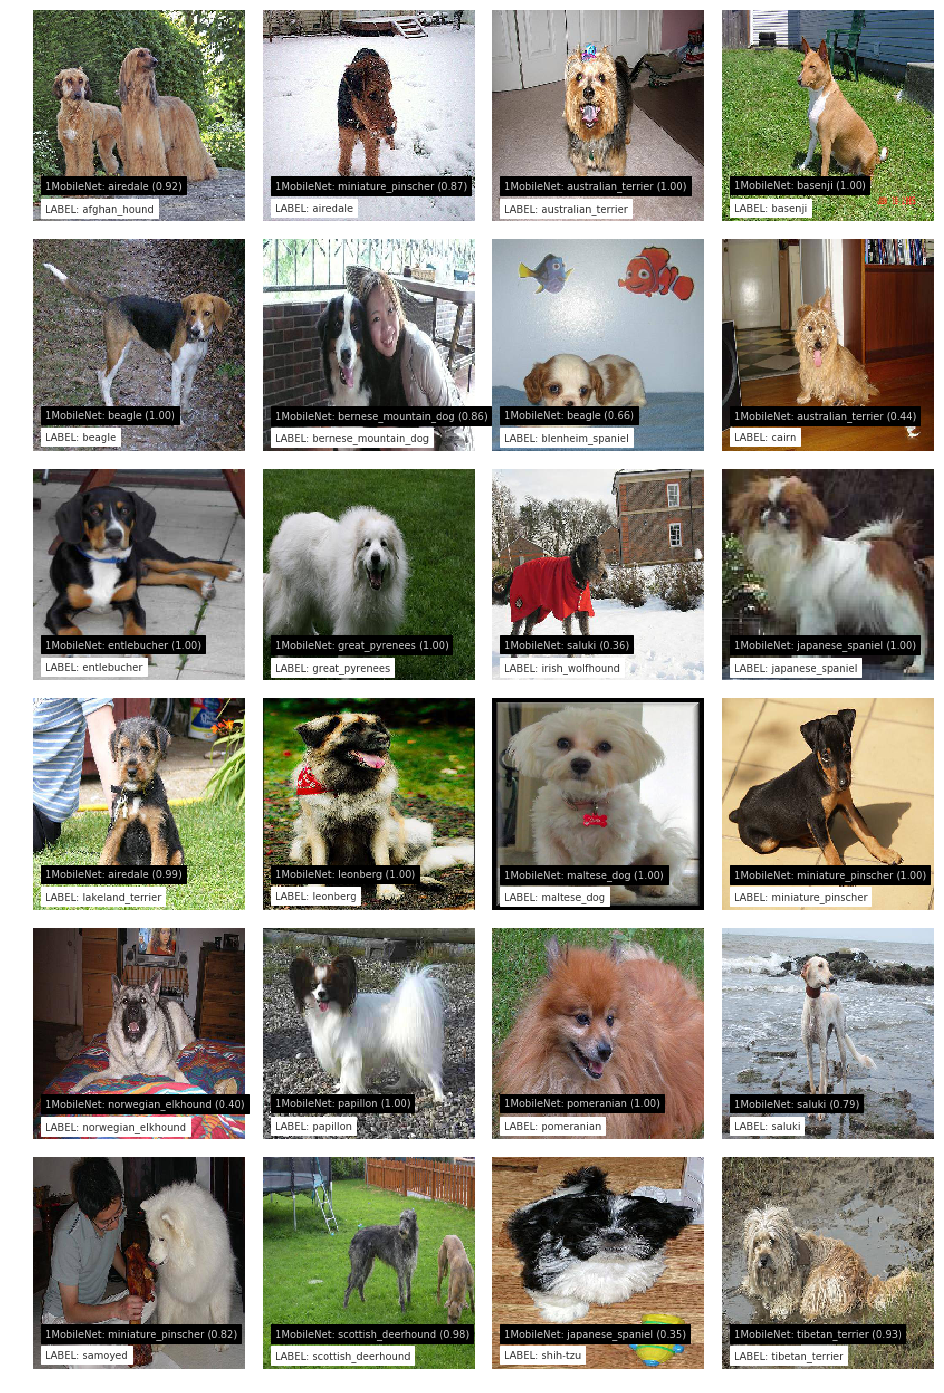

In [205]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.applications.vgg16 import preprocess_input, decode_predictions
#from os.path import join

NUM_CLASSES = 24

j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(25, 25))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.25)
for i, (breed, img_id) in enumerate(val_files):
    ax = grid[i]
    img = read_img('Dog Breed/val_top_24/%s/%s' % (breed, img_id), (pic_dimension, pic_dimension))
    ax.imshow(img / 255.)
    #x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x = np.expand_dims(img.copy(), axis=0)
    x = x/255
    preds = modelo_9.predict(x)
    #_, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 160, '1MobileNet: %s (%.2f)' % (val_files[:,0][np.argmax(preds)], np.max(preds)), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 180, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()